# BP_Prediction2: SBP/DBP 시각화 (p008141.mat)
p008141.mat에서 SBP/DBP를 로드하여 분포와 스캐터를 그립니다.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scipy(v5/v7) 또는 h5py(v7.3)로 .mat 로드
def load_mat_any(path):
    data = {}
    try:
        from scipy.io import loadmat
        raw = loadmat(path, squeeze_me=True, struct_as_record=False)
        data = {k: v for k, v in raw.items() if not k.startswith('__')}
        return data
    except Exception as e:
        err = str(e)
    try:
        import h5py
        def _read_h5_group(g, prefix=''):
            out = {}
            for k, v in g.items():
                name = f"{prefix}{k}"
                if isinstance(v, h5py.Group):
                    out.update(_read_h5_group(v, name + '/'))
                else:
                    try:
                        arr = v[()]
                        out[name] = np.array(arr)
                    except Exception:
                        pass
            return out
        with h5py.File(path, 'r') as f:
            data = _read_h5_group(f, '')
        return data
    except Exception as e2:
        raise RuntimeError(f".mat 로드 실패: scipy/h5py 모두 불가\n- scipy err: {err}\n- h5 err: {e2}")

def find_var(d, keys):
    lowered = {k.lower(): k for k in d.keys()}
    for key in keys:
        lk = key.lower()
        if lk in lowered:
            return lowered[lk], d[lowered[lk]]
    for lk, orig in lowered.items():
        if any(k.lower() in lk for k in keys):
            return orig, d[orig]
    return None, None

def to_1d_num(a):
    a = np.array(a).astype(float).ravel()
    a = a[np.isfinite(a)]
    return a


In [11]:
# 1) 데이터 로드 및 변수 확인
path = 'p008141.mat'
data = load_mat_any(path)
print(f'변수 목록({len(data)}):', list(data.keys())[:50], '...')


변수 목록(77589): ['#refs#/0', '#refs#/00', '#refs#/00b', '#refs#/00c', '#refs#/00d', '#refs#/00e', '#refs#/00f', '#refs#/00g', '#refs#/00h', '#refs#/00i', '#refs#/00j', '#refs#/00k', '#refs#/00l', '#refs#/00m', '#refs#/00n', '#refs#/00o', '#refs#/00p', '#refs#/00q', '#refs#/00r', '#refs#/00s', '#refs#/00t', '#refs#/01', '#refs#/01b', '#refs#/01c', '#refs#/01d', '#refs#/01e', '#refs#/01f', '#refs#/01g', '#refs#/01h', '#refs#/01i', '#refs#/01j', '#refs#/01k', '#refs#/01l', '#refs#/01m', '#refs#/01n', '#refs#/01o', '#refs#/01p', '#refs#/01q', '#refs#/01r', '#refs#/01s', '#refs#/01t', '#refs#/02', '#refs#/02b', '#refs#/02c', '#refs#/02d', '#refs#/02e', '#refs#/02f', '#refs#/02g', '#refs#/02h', '#refs#/02i'] ...


In [12]:
# 3) HDF5 구조 확인: Subj_Wins 키 나열 (v7.3 구조)
import h5py
with h5py.File('p008141.mat', 'r') as f:
    if 'Subj_Wins' in f:
        subj = f['Subj_Wins']
        keys = sorted(subj.keys())
        print(f'Subj_Wins columns: {len(keys)}')
        print(keys[:20])
    else:
        print('Subj_Wins 그룹이 없습니다. MAT 버전을 확인하세요.')


Subj_Wins columns: 28
['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks']


Rows loaded: 2770
         count       mean        std        min        25%        50%  \
SegSBP  2770.0  98.710084  13.103998  76.079926  88.711511  95.414476   
SegDBP  2770.0  61.468082   5.182860  50.743129  58.318667  60.889799   

               75%         max  
SegSBP  106.362300  154.459032  
SegDBP   64.360595   96.008487  


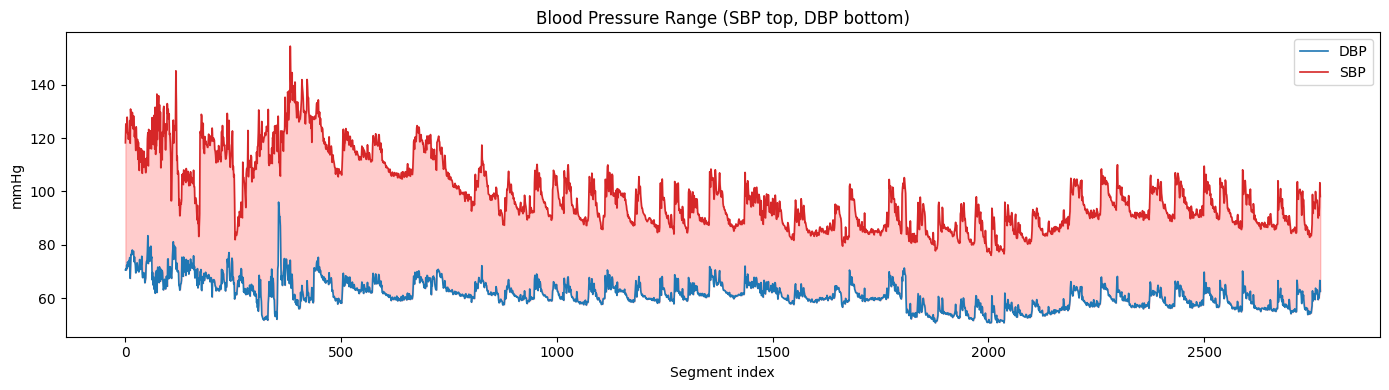

In [13]:
# 4) v7.3(HDF5) 레이아웃에서 SegSBP/SegDBP 추출 및 시각화
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

def _resolve_ref(file: h5py.File, ref):
    value = file[ref][()]
    array = np.array(value)
    if array.dtype.kind in {'S', 'U'}:
        flat = array.ravel().astype(str)
        return ''.join(flat)
    array = np.squeeze(array)
    if isinstance(array, np.ndarray) and array.dtype.kind in {'i','u'} and array.size > 1:
        return ''.join(chr(int(x)) for x in array)
    if isinstance(array, np.ndarray) and array.size == 1:
        return array.item()
    return array

def extract_scalar_table(h5_path, columns):
    records = {col: [] for col in columns}
    with h5py.File(h5_path, 'r') as f:
        subj = f['Subj_Wins']
        for col in columns:
            ds = subj[col]
            row = ds[0] if ds.ndim > 1 else ds[:]
            for ref in row:
                records[col].append(_resolve_ref(f, ref))
    return pd.DataFrame(records)

cols = ['SubjectID','SegmentID','WinID','WinSeqID','Age','Gender','IncludeFlag','PPG_ABP_Corr','SegSBP','SegDBP']
df = extract_scalar_table('p008141.mat', cols)
# 타입 정리
num_cols = ['Age','PPG_ABP_Corr','SegSBP','SegDBP']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
for c in ['SegmentID','WinID','WinSeqID','Gender','IncludeFlag']:
    df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
df['SubjectID'] = df['SubjectID'].astype(str)

print('Rows loaded:', len(df))
print(df[['SegSBP','SegDBP']].describe().T)

# BP 범위 밴드 플롯 (정렬 없이 인덱스 기준)
sbp = df['SegSBP'].to_numpy(dtype=float)
dbp = df['SegDBP'].to_numpy(dtype=float)
mask = np.isfinite(sbp) & np.isfinite(dbp)
sbp = sbp[mask]; dbp = dbp[mask]
sbp = sbp[(sbp >= 60) & (sbp <= 240)]
dbp = dbp[(dbp >= 30) & (dbp <= 150)]
n = min(len(sbp), len(dbp))
if n > 0:
    max_n = n
    x = np.arange(max_n)
    dbp_s = dbp[:max_n]; sbp_s = sbp[:max_n]
    plt.figure(figsize=(14,4))
    plt.plot(x, dbp_s, color='#1f77b4', linewidth=1.2, label='DBP')
    plt.plot(x, sbp_s, color='#d62728', linewidth=1.2, label='SBP')
    plt.fill_between(x, dbp_s, sbp_s, color='red', alpha=0.2)
    plt.title('Blood Pressure Range (SBP top, DBP bottom)')
    plt.xlabel('Segment index'); plt.ylabel('mmHg')
    plt.legend(loc='best')
    plt.tight_layout(); plt.show()
else:
    plt.figure()
    plt.text(0.5, 0.5, '범위 플롯 생성 불가(길이 0)', ha='center', va='center'); plt.axis('off')
    plt.show()


## 5) PPG-only 1D CNN Regression (5 folds, 400/300/50/50)

In [14]:
# Prepare arrays: PPG waveform matrix and targets (SegSBP, SegDBP)
import numpy as np
import h5py
import pandas as pd

def extract_waveform_matrix(h5_path: str, key: str) -> np.ndarray:
    arrays = []
    with h5py.File(h5_path, 'r') as f:
        ds = f['Subj_Wins'][key][0]
        for ref in ds:
            waveform = np.array(f[ref][()], dtype=np.float32).ravel()
            arrays.append(waveform)
    lengths = {arr.shape[0] for arr in arrays}
    if len(lengths) != 1:
        raise ValueError(f'Waveforms have inconsistent lengths for {key}: {lengths}')
    return np.stack(arrays)

cols = ['SubjectID','SegmentID','WinID','WinSeqID','Age','Gender','IncludeFlag','PPG_ABP_Corr','SegSBP','SegDBP']
df = extract_scalar_table('p008141.mat', cols)
for c in ['SegSBP','SegDBP','Age','PPG_ABP_Corr']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df['IncludeFlag'] = pd.to_numeric(df['IncludeFlag'], errors='coerce').astype('Int64')

ppg_matrix = extract_waveform_matrix('p008141.mat', 'PPG_Raw')
targets = df[['SegSBP','SegDBP']].to_numpy(dtype=np.float32)
flags = df['IncludeFlag'].fillna(0).to_numpy()
mask = (flags == 1) & np.isfinite(targets).all(axis=1)
ppg_matrix = ppg_matrix[mask]
targets = targets[mask]

FOLD_SIZE = 400
NUM_FOLDS = 5
required = NUM_FOLDS * FOLD_SIZE
total_segments = ppg_matrix.shape[0]
if total_segments < required:
    raise RuntimeError(f'Not enough quality segments: {total_segments} (need \u2265 {required})')
# keep the most recent/high-index segments so folds use the stable tail of the recording
start_idx = total_segments - required
ppg_matrix = ppg_matrix[start_idx:]
targets = targets[start_idx:]

features = np.expand_dims(ppg_matrix, axis=1).astype(np.float32)  # (N, 1, L)
N, C, L = features.shape
print('Features:', features.shape, 'Targets:', targets.shape)


Features: (2000, 1, 1250) Targets: (2000, 2)


In [15]:
# CNN model and training utilities
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class BPRegressorCNN(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 16, kernel_size=7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=7, padding=3), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        h = self.net(x)
        return self.head(h)

def compute_metrics(y_true, y_pred):
    with torch.no_grad():
        err = y_pred - y_true
        mse = (err**2).mean(dim=0)
        rmse = torch.sqrt(mse)
        mae = err.abs().mean(dim=0)
        return mae.cpu().numpy(), rmse.cpu().numpy()

def normalize_channelwise(x_train, x_other):
    mean = x_train.mean(axis=(0,2), keepdims=True)
    std = x_train.std(axis=(0,2), keepdims=True) + 1e-6
    return (x_train-mean)/std, (x_other-mean)/std, mean, std

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 20
BATCH_SIZE = 64
LR = 1e-3
torch.manual_seed(42); np.random.seed(42)


In [16]:
# 5-fold training/evaluation (per-fold 300/50/50 within the 400-segment block)
fold_size = 400
train_size = 300
val_size = 50
test_size = 50
num_folds = 5
assert N >= num_folds*fold_size

per_fold = []
for k in range(num_folds):
    start = k*fold_size
    tr = slice(start, start+train_size)
    va = slice(start+train_size, start+train_size+val_size)
    te = slice(start+train_size+val_size, start+fold_size)

    x_tr = features[tr]
    y_tr = targets[tr]
    x_va = features[va]
    y_va = targets[va]
    x_te = features[te]
    y_te = targets[te]

    x_tr_n, x_va_n, mean, std = normalize_channelwise(x_tr, x_va)
    x_te_n = (x_te - mean)/std

    dl_tr = DataLoader(TensorDataset(x_tr_n, y_tr), batch_size=BATCH_SIZE, shuffle=True)
    dl_va = DataLoader(TensorDataset(x_va_n, y_va), batch_size=BATCH_SIZE)
    dl_te = DataLoader(TensorDataset(x_te_n, y_te), batch_size=BATCH_SIZE)

    model = BPRegressorCNN(1).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.MSELoss()

    best_val = float('inf'); best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward(); opt.step()
        # validate
        model.eval()
        val_loss = 0.0; nval = 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                l = crit(model(xb), yb).item()
                val_loss += l * xb.size(0); nval += xb.size(0)
        val_loss /= max(1, nval)
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    # test metrics
    model.eval()
    y_true = []; y_pred = []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(DEVICE)
            pred = model(xb).cpu()
            y_true.append(yb); y_pred.append(pred)
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    mae, rmse = compute_metrics(y_true, y_pred)
    print(f'Fold {k+1}: MAE(SBP)={mae[0]:.3f}, MAE(DBP)={mae[1]:.3f}, RMSE(SBP)={rmse[0]:.3f}, RMSE(DBP)={rmse[1]:.3f}')
    per_fold.append({'mae_sbp':mae[0], 'mae_dbp':mae[1], 'rmse_sbp':rmse[0], 'rmse_dbp':rmse[1]})

# summary
import numpy as np
mae_sbp = np.array([d['mae_sbp'] for d in per_fold]); mae_dbp = np.array([d['mae_dbp'] for d in per_fold])
rmse_sbp = np.array([d['rmse_sbp'] for d in per_fold]); rmse_dbp = np.array([d['rmse_dbp'] for d in per_fold])
print('-'*60)
print(f'MAE(SBP): mean={mae_sbp.mean():.3f} std={mae_sbp.std(ddof=1):.3f}')
print(f'MAE(DBP): mean={mae_dbp.mean():.3f} std={mae_dbp.std(ddof=1):.3f}')
print(f'RMSE(SBP): mean={rmse_sbp.mean():.3f} std={rmse_sbp.std(ddof=1):.3f}')
print(f'RMSE(DBP): mean={rmse_dbp.mean():.3f} std={rmse_dbp.std(ddof=1):.3f}')
avg_mae = (mae_sbp + mae_dbp)/2; avg_rmse = (rmse_sbp + rmse_dbp)/2
print(f'Avg MAE: mean={avg_mae.mean():.3f} std={avg_mae.std(ddof=1):.3f}')
print(f'Avg RMSE: mean={avg_rmse.mean():.3f} std={avg_rmse.std(ddof=1):.3f}')


Fold 1: MAE(SBP)=6.075, MAE(DBP)=3.676, RMSE(SBP)=7.463, RMSE(DBP)=4.684
Fold 2: MAE(SBP)=7.682, MAE(DBP)=3.167, RMSE(SBP)=8.408, RMSE(DBP)=3.538
Fold 3: MAE(SBP)=5.027, MAE(DBP)=2.210, RMSE(SBP)=6.037, RMSE(DBP)=2.666
Fold 4: MAE(SBP)=6.762, MAE(DBP)=2.516, RMSE(SBP)=7.350, RMSE(DBP)=2.926
Fold 5: MAE(SBP)=5.105, MAE(DBP)=3.221, RMSE(SBP)=5.965, RMSE(DBP)=4.008
------------------------------------------------------------
MAE(SBP): mean=6.130 std=1.127
MAE(DBP): mean=2.958 std=0.588
RMSE(SBP): mean=7.044 std=1.038
RMSE(DBP): mean=3.564 std=0.816
Avg MAE: mean=4.544 std=0.688
Avg RMSE: mean=5.304 std=0.720
